In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile
import pandas as pd
import numpy as np
import datetime
import xml.etree.ElementTree as ET
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
from sklearn.linear_model import LinearRegression
import os
import matplotlib.pyplot as plt


In [3]:
# Specify the path to the ZIP file
zip_file_path = '/content/drive/MyDrive/OhioT1DM.zip'

# Specify the directory to extract the contents of the ZIP file
extract_dir = "/content/drive/MyDrive/OhioT1DM"

# Password for encrypted files if applicable
password = "...@@@!!==/\/\/\/\~~~~~BGLP-1804-BGLP~~~~~/\/\/\/\==!!@@@..."

# Create the extraction directory if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

# Extract the contents of the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    for member in zip_ref.infolist():
        # Check if the file is encrypted
        if member.flag_bits & 0x01:
            zip_ref.extract(member, extract_dir, pwd=password.encode())
        else:
            zip_ref.extract(member, extract_dir)

print("Extraction completed successfully.")


Extraction completed successfully.


In [4]:
# code for reading the xml files is influenced/copied by https://github.com/r-cui/GluPred/blob/master/preprocess/loader.py

# this function extracts the glucose data from the xml files (features are the glucose value and the time)
# then the data is rounded and resampled to 5 minutes
# rounding can cause duplicates as to why only the first value is kept
# resampling is needed to create a uniform time sequence and identify gaps
def get_glc(root):
    glucose = []
    glucose_ts = []
    for type_tag in root.findall('glucose_level/event'):
        value = type_tag.get('value')
        ts = type_tag.get('ts')
        ts = datetime.datetime.strptime(ts, "%d-%m-%Y %H:%M:%S")
        glucose.append(int(value))
        glucose_ts.append(ts)

    df_glc = pd.DataFrame({'ts': glucose_ts, 'glucose': glucose})

    # Convert 'ts' to a proper DatetimeIndex
    df_glc['ts'] = pd.to_datetime(df_glc['ts'])
    df_glc = df_glc.set_index('ts')

    # Resample data to 5-minute intervals
    df_glc = df_glc.resample("5min").asfreq().reset_index()

    return df_glc


# Function to extract meal data from XML
def get_meal(root):
    carbs = []
    meal_ts = []
    for type_tag in root.findall('meal/event'):
        value = type_tag.get('carbs')
        ts = type_tag.get('ts')
        ts = datetime.datetime.strptime(ts, "%d-%m-%Y %H:%M:%S")
        carbs.append(float(value))
        meal_ts.append(ts)

    meal_frame = [meal_ts, carbs]
    meal_frame = np.array(meal_frame)
    df_meal = pd.DataFrame(meal_frame.T, columns=['ts', 'carbs'])

    # Round the timestamp to 5-minute intervals
    df_meal['ts'] = pd.to_datetime(df_meal['ts'])
    df_meal = df_meal.set_index('ts').resample('5min').ffill().reset_index()

    return df_meal

# this function extracts the basal insulin from the xml file which consists of the attributs: basal, temp_basal, and bolus
# basal and temp_basal need to be combined and the original basal value is replaced wtih temp_basal
# furthermore, basal is resampled to 5 minutes and the missing values are filled with the prior values
# as basal is applied continously, it only changes when a new basal rate is set

def get_basal(root):
    basal = []
    basal_ts = []

    for type_tag in root.findall('basal/event'):
        value = type_tag.get('value')
        ts = type_tag.get('ts')
        ts = datetime.datetime.strptime(ts, "%d-%m-%Y %H:%M:%S")
        basal.append(float(value))
        basal_ts.append(ts)

    basal_frame = [basal_ts, basal]
    basal_frame = np.array(basal_frame)
    df_basal = pd.DataFrame(basal_frame.T, columns=['ts', 'basal'])

    df_basal["ts"] = pd.to_datetime(df_basal["ts"])

    df_basal = df_basal.set_index('ts')
    df_basal = df_basal.resample("5min").ffill()
    df_basal = df_basal.reset_index()

    return df_basal


# temp_basal is a temporary dosage replacing the original basal rate, with a value of 0 the basal rate is suspended

def get_temp_basal(root):
    temp_basal = []
    temp_basal_ts = []
    temp_basal_dur = []

    for type_tag in root.findall('temp_basal/event'):
        value = type_tag.get('value')
        ts = type_tag.get('ts_begin')
        ts_end = type_tag.get('ts_end')
        ts = datetime.datetime.strptime(ts, "%d-%m-%Y %H:%M:%S")
        ts_end = datetime.datetime.strptime(ts_end, "%d-%m-%Y %H:%M:%S")
        temp_basal_dur.append(ts_end)
        temp_basal.append(float(value))
        temp_basal_ts.append(ts)

    temp_basal_frame = [temp_basal_ts, temp_basal, temp_basal_dur]
    temp_basal_frame = np.array(temp_basal_frame)
    df_temp_basal = pd.DataFrame(temp_basal_frame.T, columns=['ts', 'temp_basal', 'basal_end'])

    df_temp_basal["ts"] = pd.to_datetime(df_temp_basal["ts"] )
    df_temp_basal["basal_end"] = pd.to_datetime(df_temp_basal["basal_end"])

    # the data is rounded to 5 minutes
    df_temp_basal["ts"] = df_temp_basal["ts"].dt.round('5min')
    df_temp_basal["basal_end"] = df_temp_basal["basal_end"].dt.round('5min')
    return df_temp_basal


# This function aims to replace temp basal with the basal value, by identifying the start and end time of
# temporal basal infusion

def combine_basal_temp_basal(df_b, df_temp_b):

    # first the basal dataframe and the dataframe with the temporal basal information are merged with a left join
    # thus all time intervals in which no temporal basal was infused gets a nan value
    # this enables to check for all instances without nan values to identify the basal dosage which needs to be replaced
    combined_df = pd.merge(df_b, df_temp_b, on='ts', how='left')
    combined_df["temp_basal"] = combined_df["temp_basal"].fillna(-1)

    for i in range (0, len(combined_df)):
        # condition to identify only the location of the basal rates which overlap with a temporal basal dosage
        if((combined_df["temp_basal"][i]  != -1)):
            start_time = combined_df["ts"][i]
            end_time = combined_df["basal_end"][i]
            # after identifying the start and end, the values are replaced with the temporal dosage
            combined_df.loc[(combined_df["ts"] >= start_time) & (combined_df["ts"] <= end_time), "basal"] = combined_df["temp_basal"][i]

    combined_df = combined_df.drop("basal_end", axis=1)
    combined_df = combined_df.drop("temp_basal", axis=1)
    # the new dataframe is returned
    return combined_df


# this function extracts the data of bolus insulin from the xml file
# bolus insulin is not infused continously, thus the start and endtime need to be identified to set the
# correct bolus for each infusion duration in the later steps
# the function returns a dataframe with the time, the bolus insulin dosage and the end time of infusion

def get_bolus(root):
    bolus = []
    bolus_ts = []
    bolus_end = []

    for type_tag in root.findall('bolus/event'):
        value = type_tag.get('dose')
        ts = type_tag.get('ts_begin')
        ts = datetime.datetime.strptime(ts, "%d-%m-%Y %H:%M:%S")
        ts_end = type_tag.get('ts_end')
        ts_end = datetime.datetime.strptime(ts_end, "%d-%m-%Y %H:%M:%S")
        bolus_ts.append(ts)
        bolus_end.append(ts_end)
        bolus.append(float(value))

    bolus_frame = [bolus_ts, bolus, bolus_end]
    bolus_frame = np.array(bolus_frame)
    df_bolus =pd.DataFrame(bolus_frame.T, columns=['ts', 'bolus', 'bolus_end'])

    # the data is rounded to 5 minutes
    df_bolus['ts'] = df_bolus['ts'].dt.round('5min')
    df_bolus["ts"] = df_bolus["ts"].drop_duplicates()

    # the data is rounded to 5 minutes
    df_bolus['bolus_end'] = df_bolus['bolus_end'].dt.round('5min')
    df_bolus['bolus_end'] = df_bolus['bolus_end'].drop_duplicates()

    return df_bolus


# this function extarcts the exercise data from the xml file for the 2018 cohort
# The problem with the exercise data is that both patient cohorts use different wearables and parameters, hence to have
# uniform data, the step count is converted to the magnitude of acceleration while the data in the 2020 cohort is kept as it is

def get_step(root):
    steps = []
    steps_ts = []
    for type_tag in root.findall('basis_steps/event'):
        value = type_tag.get('value')
        ts = type_tag.get('ts')
        ts = datetime.datetime.strptime(ts, "%d-%m-%Y %H:%M:%S")
        steps.append(int(value))
        steps_ts.append(ts)

    steps_frame = [steps_ts, steps]
    steps_frame = np.array(steps_frame)
    df_steps = pd.DataFrame(steps_frame.T, columns=['ts', 'steps'])

    # the data is rounded to 5 minutes
    df_steps['ts'] = df_steps['ts'].dt.round('5min')
    df_steps['ts'] = df_steps['ts'].drop_duplicates()

    # self reported sleep data is read to compensate for possible missing values during the night
    df_sleep = get_sleep(root)
    # step count values are replaced with 0 if the subject sleeps
    combined_df = combine_step_sleep(df_steps, df_sleep)
    # step count is converted to magnitude of acceleration
    df_macc = convert_step_to_MOA(combined_df)

    return df_macc


# the step count could have missing values as to why the sleep time information is extracted to include 0 activity while sleeping
# this functions extracts the reported time intervals of sleep and returns a dataframe with start and end time

def get_sleep(root):
    sleep_start = []
    sleep_end = []
    for type_tag in root.findall('sleep/event'):
        start = type_tag.get('ts_end')
        end = type_tag.get('ts_begin')
        start = datetime.datetime.strptime(start, "%d-%m-%Y %H:%M:%S")
        end = datetime.datetime.strptime(end, "%d-%m-%Y %H:%M:%S")
        sleep_start.append(start)
        sleep_end.append(end)

    sleep_frame = [sleep_start, sleep_end]
    sleep_frame = np.array(sleep_frame)
    df_sleep = pd.DataFrame(sleep_frame.T, columns=['ts', 'sleep_end'])

    # the data is rounded to 5 minutes
    df_sleep['ts'] = df_sleep['ts'].dt.round('5min')
    df_sleep['sleep_end'] = df_sleep['sleep_end'].dt.round('5min')

    return df_sleep


# this function merges the step count with the reported sleep intervals and replaces the values with 0 if the person was sleeping

def combine_step_sleep(df_step, df_sleep):


    combined_df = pd.merge(df_step, df_sleep, on='ts', how='left')
    combined_df["steps"] = combined_df["steps"].fillna(-1)

    for i in range (0, len(combined_df)):
        if((combined_df["steps"][i]  != -1)):
            start_time = combined_df["ts"][i]
            end_time = combined_df["sleep_end"][i]
            # condition is checked and values are replaced
            combined_df.loc[(combined_df["ts"] >= start_time) & (combined_df["sleep_end"] <= end_time), "steps"] = 0

    combined_df = combined_df.drop("sleep_end", axis=1)

    return combined_df


'''
formulas are taken from:
https://www.omnicalculator.com/physics/velocity : velocity
https://www.omnicalculator.com/physics/magnitude-of-acceleration : acceleration and magnitude of acceleration

- The formula for the magnitude of acceleration is the absolute value of the acceleration with a formula of |a| = sqrt(pow(x))
- x in this case is the acceleration computed by the change in velocity divided by the time interval
- so for converting step count into the magnitude of acceleration, the first step is to compute the velocity from the distance divided by the needed time
- velocity = distance/time
- acc = change in velocity/ change in time
- moacc = |a| = sqrt(pow(x)) -> the absolute value was not taken since the 2020 also indicate negative acceleration

1. First, the step count is converted to a distance of meters. Here, according to research the standard equality is 1 step = 0.74 - 0.76 meters.
    -> velocity = (step count * 0.75) / (5)
2. Secondly, the acceleration is calcualted from subtracting the considered velocity from the previous velocity (initial) and divide it again by (5)
'''

def convert_step_to_MOA(df_steps):
    time_interval = 5

    df_steps['steps'] = df_steps['steps'].mul(0.75)
    df_steps['velocity'] = df_steps['steps'].div(time_interval)
    df_steps.loc[(df_steps["steps"] == 0), "velocity"] = 0.0
    df_steps['prior_velocity'] = df_steps['velocity'].shift(1, axis=0)
    df_steps['difference'] = df_steps['velocity'] - df_steps['prior_velocity']
    df_steps['acc'] = df_steps['difference'].div(time_interval)
    df_steps['macc'] = df_steps['acc']

    # here if the actual and prior velocity are 0 the value is set to 0 as well to not cause infinitiy values irritating the computation
    df_steps.loc[(df_steps["velocity"] == 0) & (df_steps["prior_velocity"] == 0) , "macc"] = 0.0

    df_macc = df_steps[['ts', 'macc']]

    # scale the data to 0 and 1
    df_min_max_scaled = df_macc.copy()
    df_min_max_scaled ['macc'] = (df_min_max_scaled['macc'] - df_min_max_scaled['macc'].min()) / (df_min_max_scaled['macc'].max() - df_min_max_scaled['macc'].min())

    # the converted dataframe is returned
    return df_min_max_scaled



# this function extracts the acceleration data for the 2020 cohort from the xml file

def get_macc(root):

    macc = []
    macc_ts = []

    for type_tag in root.findall('acceleration/event'):
        value = type_tag.get('value')
        ts = type_tag.get('ts')
        ts = datetime.datetime.strptime(ts, "%d-%m-%Y %H:%M:%S")
        macc.append(float(value))
        macc_ts.append(ts)
    macc_frame = [macc_ts, macc]
    macc_frame = np.array(macc_frame)
    df_macc = pd.DataFrame(macc_frame.T, columns=['ts', 'macc'])

    # it is resampled to 5 minutes and sum the magnitude of the single minutes, so that every 5 minutes the MoA summed over 5 minutes is presented
    # since the acceleration is reported in one minute intervals
    df_macc = df_macc.set_index('ts')
    df_macc = df_macc.resample("5min").sum()
    df_macc = df_macc.reset_index()
    # 0.0 possibly meant missing values
    df_macc = df_macc.replace(0.0, np.nan)

    # scale the data to 0 and 1
    df_min_max_scaled = df_macc.copy()
    df_min_max_scaled ['macc'] = (df_min_max_scaled['macc'] - df_min_max_scaled['macc'].min()) / (df_min_max_scaled['macc'].max() - df_min_max_scaled['macc'].min())

    return df_min_max_scaled


In [132]:
# Convert 'ts' to datetime for all dataframes before merging
def ensure_datetime(df):
    if 'ts' in df.columns:
        df['ts'] = pd.to_datetime(df['ts'], errors='coerce')  # Convert to datetime, handle errors
    return df

# Updated function to load data and ensure 'ts' is datetime64[ns] format
def load_data(TRAINFILE, TESTFILE, s_ID, version):
    count = 0
    for i in range(0, len(TRAINFILE)):
        train_file = TRAINFILE[i]
        test_file = TESTFILE[i]

        # Check if files exist before attempting to parse them
        if not os.path.isfile(train_file):
            print(f"Train file {train_file} not found. Skipping this file.")
            continue
        if not os.path.isfile(test_file):
            print(f"Test file {test_file} not found. Skipping this file.")
            continue

        print(f"Parsing train file: {train_file}")
        root = ET.parse(train_file).getroot()

        print(f"Parsing test file: {test_file}")
        root2 = ET.parse(test_file).getroot()

        subject_ID = s_ID[count]
        count += 1

        # Process glucose, insulin, meal, activity data
        df_glc = ensure_datetime(get_glc(root))
        df_basal = ensure_datetime(get_basal(root))
        df_bolus = ensure_datetime(get_bolus(root))
        df_temp_basal = ensure_datetime(get_temp_basal(root))
        df_meal = ensure_datetime(get_meal(root))

        if version == 2018:
            df_macc = ensure_datetime(get_step(root))
        else:
            df_macc = ensure_datetime(get_macc(root))

        # Ensure 'ts' is uniformly in datetime format for all train dataframes
        df_list_train = [df_glc, df_basal, df_bolus, df_macc, df_meal]
        for df in df_list_train:
            df = ensure_datetime(df)
            df.drop_duplicates(subset=['ts'], inplace=True)

        # Merge train dataframes on 'ts'
        combined_df_train = df_list_train[0]
        for df in df_list_train[1:]:
            combined_df_train = pd.merge(combined_df_train, df, on='ts', how='left')

        # Process test data
        df_glc2 = ensure_datetime(get_glc(root2))
        df_basal2 = ensure_datetime(get_basal(root2))
        df_bolus2 = ensure_datetime(get_bolus(root2))
        df_temp_basal2 = ensure_datetime(get_temp_basal(root2))
        df_meal2 = ensure_datetime(get_meal(root2))

        if version == 2018:
            df_macc2 = ensure_datetime(get_step(root2))
        else:
            df_macc2 = ensure_datetime(get_macc(root2))

        # Ensure 'ts' is uniformly in datetime format for all test dataframes
        df_list_test = [df_glc2, df_basal2, df_bolus2, df_macc2, df_meal2]
        for df in df_list_test:
            df = ensure_datetime(df)
            df.drop_duplicates(subset=['ts'], inplace=True)

        # Merge test dataframes on 'ts'
        combined_df_test = df_list_test[0]
        for df in df_list_test[1:]:
            combined_df_test = pd.merge(combined_df_test, df, on='ts', how='left')

        # Concatenate train and test data
        combined_df = pd.concat([combined_df_train, combined_df_test], ignore_index=True)
        combined_df["Subject_ID"] = subject_ID

        # Combine basal and temp basal
        combined_df = combine_basal_temp_basal(combined_df, df_temp_basal)
        combined_df = combine_basal_temp_basal(combined_df, df_temp_basal2)

        # Handle bolus insulin
        for i in range(len(combined_df)):
            if not pd.isna(combined_df["bolus"][i]):
                start_time = combined_df["ts"][i]
                end_time = combined_df["bolus_end"][i]
                combined_df.loc[(combined_df["ts"] >= start_time) & (combined_df["ts"] <= end_time), "bolus"] = combined_df["bolus"][i]
        combined_df = combined_df.drop("bolus_end", axis=1)

        # Convert columns to float
        for col in ['glucose', 'basal', 'bolus', 'macc', 'carbs']:
            combined_df[col] = combined_df[col].astype(float)

        # Fill missing basal insulin values
        combined_df['basal'] = combined_df['basal'].ffill().bfill()

        # Fill missing bolus insulin values with 0
        combined_df['bolus'] = combined_df['bolus'].fillna(0)

        # Fill missing glucose and macc values using interpolation and extrapolation
        combined_df = combined_df.interpolate(method="linear", limit=24, limit_direction="both")
        combined_df['macc'] = combined_df['macc'].fillna(-1)

        # Fill missing carbs values with the mean of carbs
        carb_mean = combined_df['carbs'].mean()
        combined_df['carbs'] = combined_df['carbs'].fillna(carb_mean)

        # Drop rows where glucose is null
        combined_df = combined_df.dropna(subset=['glucose'])

        return combined_df


In [147]:
# Convert 'ts' to datetime for all dataframes before merging
def ensure_datetime(df):
    if 'ts' in df.columns:
        df['ts'] = pd.to_datetime(df['ts'], errors='coerce')  # Convert to datetime, handle errors
    return df

# Updated function to load data and ensure 'ts' is datetime64[ns] format
def load_data(TRAINFILE, TESTFILE, s_ID, version):
    count = 0
    for i in range(0, len(TRAINFILE)):
        train_file = TRAINFILE[i]
        test_file = TESTFILE[i]

        # Check if files exist before attempting to parse them
        if not os.path.isfile(train_file):
            print(f"Train file {train_file} not found. Skipping this file.")
            continue
        if not os.path.isfile(test_file):
            print(f"Test file {test_file} not found. Skipping this file.")
            continue

        print(f"Parsing train file: {train_file}")
        root = ET.parse(train_file).getroot()

        print(f"Parsing test file: {test_file}")
        root2 = ET.parse(test_file).getroot()

        subject_ID = s_ID[count]
        count += 1

        # Process glucose, insulin, meal, activity data
        df_glc = ensure_datetime(get_glc(root))
        df_basal = ensure_datetime(get_basal(root))
        df_bolus = ensure_datetime(get_bolus(root))
        df_temp_basal = ensure_datetime(get_temp_basal(root))
        df_meal = ensure_datetime(get_meal(root))

        if version == 2018:
            df_macc = ensure_datetime(get_step(root))
        else:
            df_macc = ensure_datetime(get_macc(root))

        # Ensure 'ts' is uniformly in datetime format for all train dataframes
        df_list_train = [df_glc, df_basal, df_bolus, df_macc, df_meal]
        for df in df_list_train:
            df = ensure_datetime(df)
            df.drop_duplicates(subset=['ts'], inplace=True)

        # Merge train dataframes on 'ts'
        combined_df_train = df_list_train[0]
        for df in df_list_train[1:]:
            df = ensure_datetime(df)  # Ensure the 'ts' column is in datetime format
            combined_df_train = pd.merge(combined_df_train, df, on='ts', how='left')

        # Process test data
        df_glc2 = ensure_datetime(get_glc(root2))
        df_basal2 = ensure_datetime(get_basal(root2))
        df_bolus2 = ensure_datetime(get_bolus(root2))
        df_temp_basal2 = ensure_datetime(get_temp_basal(root2))
        df_meal2 = ensure_datetime(get_meal(root2))

        if version == 2018:
            df_macc2 = ensure_datetime(get_step(root2))
        else:
            df_macc2 = ensure_datetime(get_macc(root2))

        # Ensure 'ts' is uniformly in datetime format for all test dataframes
        df_list_test = [df_glc2, df_basal2, df_bolus2, df_macc2, df_meal2]
        for df in df_list_test:
            df = ensure_datetime(df)
            df.drop_duplicates(subset=['ts'], inplace=True)

        # Merge test dataframes on 'ts'
        combined_df_test = df_list_test[0]
        for df in df_list_test[1:]:
            df = ensure_datetime(df)  # Ensure the 'ts' column is in datetime format
            combined_df_test = pd.merge(combined_df_test, df, on='ts', how='left')

        # Concatenate train and test data
        combined_df = pd.concat([combined_df_train, combined_df_test], ignore_index=True)
        combined_df["Subject_ID"] = subject_ID

        # Combine basal and temp basal
        combined_df = combine_basal_temp_basal(combined_df, df_temp_basal)
        combined_df = combine_basal_temp_basal(combined_df, df_temp_basal2)

        # Handle bolus insulin
        for i in range(len(combined_df)):
            if not pd.isna(combined_df["bolus"][i]):
                start_time = combined_df["ts"][i]
                end_time = combined_df["bolus_end"][i]
                combined_df.loc[(combined_df["ts"] >= start_time) & (combined_df["ts"] <= end_time), "bolus"] = combined_df["bolus"][i]
        combined_df = combined_df.drop("bolus_end", axis=1)

        # Convert columns to float
        for col in ['glucose', 'basal', 'bolus', 'macc', 'carbs']:
            combined_df[col] = combined_df[col].astype(float)

        # Fill missing basal insulin values
        combined_df['basal'] = combined_df['basal'].ffill().bfill()

        # Fill missing bolus insulin values with 0
        combined_df['bolus'] = combined_df['bolus'].fillna(0)

        # Fill missing glucose and macc values using interpolation and extrapolation
        combined_df = combined_df.interpolate(method="linear", limit=24, limit_direction="both")
        combined_df['macc'] = combined_df['macc'].fillna(-1)

        # Fill missing carbs values with the mean of carbs
        carb_mean = combined_df['carbs'].mean()
        combined_df['carbs'] = combined_df['carbs'].fillna(carb_mean)

        # Drop rows where glucose is null
        combined_df = combined_df.dropna(subset=['glucose'])

        return combined_df


In [157]:
# Convert 'ts' to datetime for all dataframes before merging
def ensure_datetime(df):
    if 'ts' in df.columns:
        df['ts'] = pd.to_datetime(df['ts'], errors='coerce')  # Convert to datetime, handle errors
    return df

# Updated function to load data and ensure 'ts' is datetime64[ns] format
def load_data(TRAINFILE, TESTFILE, s_ID, version):
    count = 0
    for i in range(0, len(TRAINFILE)):
        train_file = TRAINFILE[i]
        test_file = TESTFILE[i]

        # Check if files exist before attempting to parse them
        if not os.path.isfile(train_file):
            print(f"Train file {train_file} not found. Skipping this file.")
            continue
        if not os.path.isfile(test_file):
            print(f"Test file {test_file} not found. Skipping this file.")
            continue

        print(f"Parsing train file: {train_file}")
        root = ET.parse(train_file).getroot()

        print(f"Parsing test file: {test_file}")
        root2 = ET.parse(test_file).getroot()

        subject_ID = s_ID[count]
        count += 1

        # Process glucose, insulin, meal, activity data
        df_glc = ensure_datetime(get_glc(root))
        df_basal = ensure_datetime(get_basal(root))
        df_bolus = ensure_datetime(get_bolus(root))
        df_temp_basal = ensure_datetime(get_temp_basal(root))
        df_meal = ensure_datetime(get_meal(root))

        if version == 2018:
            df_macc = ensure_datetime(get_step(root))
        else:
            df_macc = ensure_datetime(get_macc(root))

        # Ensure 'ts' is uniformly in datetime format for all train dataframes
        df_list_train = [df_glc, df_basal, df_bolus, df_macc, df_meal]
        for df in df_list_train:
            df = ensure_datetime(df)
            df.drop_duplicates(subset=['ts'], inplace=True)

        # Ensure 'ts' column is consistently datetime in both sides before merging
        combined_df_train = df_list_train[0]
        for df in df_list_train[1:]:
            df = ensure_datetime(df)  # Ensure the 'ts' column is in datetime format
            combined_df_train = pd.merge(combined_df_train, df, on='ts', how='left')

        # Process test data
        df_glc2 = ensure_datetime(get_glc(root2))
        df_basal2 = ensure_datetime(get_basal(root2))
        df_bolus2 = ensure_datetime(get_bolus(root2))
        df_temp_basal2 = ensure_datetime(get_temp_basal(root2))
        df_meal2 = ensure_datetime(get_meal(root2))

        if version == 2018:
            df_macc2 = ensure_datetime(get_step(root2))
        else:
            df_macc2 = ensure_datetime(get_macc(root2))

        # Ensure 'ts' is uniformly in datetime format for all test dataframes
        df_list_test = [df_glc2, df_basal2, df_bolus2, df_macc2, df_meal2]
        for df in df_list_test:
            df = ensure_datetime(df)
            df.drop_duplicates(subset=['ts'], inplace=True)

        # Ensure 'ts' column is consistently datetime in both sides before merging
        combined_df_test = df_list_test[0]
        for df in df_list_test[1:]:
            df = ensure_datetime(df)  # Ensure the 'ts' column is in datetime format
            combined_df_test = pd.merge(combined_df_test, df, on='ts', how='left')

        # Concatenate train and test data
        combined_df = pd.concat([combined_df_train, combined_df_test], ignore_index=True)
        combined_df["Subject_ID"] = subject_ID

        # Combine basal and temp basal
        combined_df = combine_basal_temp_basal(combined_df, df_temp_basal)
        combined_df = combine_basal_temp_basal(combined_df, df_temp_basal2)

        # Handle bolus insulin
        for i in range(len(combined_df)):
            if not pd.isna(combined_df["bolus"][i]):
                start_time = combined_df["ts"][i]
                end_time = combined_df["bolus_end"][i]
                combined_df.loc[(combined_df["ts"] >= start_time) & (combined_df["ts"] <= end_time), "bolus"] = combined_df["bolus"][i]
        combined_df = combined_df.drop("bolus_end", axis=1)

        # Convert columns to float
        for col in ['glucose', 'basal', 'bolus', 'macc', 'carbs']:
            combined_df[col] = combined_df[col].astype(float)

        # Fill missing basal insulin values
        combined_df['basal'] = combined_df['basal'].ffill().bfill()

        # Fill missing bolus insulin values with 0
        combined_df['bolus'] = combined_df['bolus'].fillna(0)

        # Fill missing glucose and macc values using interpolation and extrapolation
        combined_df = combined_df.interpolate(method="linear", limit=24, limit_direction="both")
        combined_df['macc'] = combined_df['macc'].fillna(-1)

        # Fill missing carbs values with the mean of carbs
        carb_mean = combined_df['carbs'].mean()
        combined_df['carbs'] = combined_df['carbs'].fillna(carb_mean)

        # Drop rows where glucose is null
        combined_df = combined_df.dropna(subset=['glucose'])

        return combined_df


In [158]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, silhouette_score, make_scorer, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV




def apply_one_class_svm(df_local):
    if df_local is None or df_local.empty:
        print("Input DataFrame is None or empty. Skipping this subject.")
        return None

    # Handle missing values
    df_local = df_local.ffill().bfill()

    # Filter normal data (glucose > 70) for training the One-Class SVM
    normal_data = df_local[df_local['glucose'] > 70]

    print(f"Number of normal glucose values (> 70): {len(normal_data)}")

    if normal_data.empty:
        print("No normal glucose data available for training (glucose > 70). Skipping this subject.")
        return None

    # Extract relevant features for training (glucose, carbs, basal, bolus, macc)
    X_train = normal_data[['glucose', 'carbs', 'basal', 'bolus', 'macc']].fillna(0)

    # Scale the features using StandardScaler
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    # Define and train the One-Class SVM model
    svm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.05)
    svm.fit(X_train_scaled)

    # Apply the model to the entire DataFrame (including glucose =< 70)
    X_all = df_local[['glucose', 'carbs', 'basal', 'bolus', 'macc']].fillna(0)
    X_all_scaled = scaler.transform(X_all)

    # Predict anomalies (hypoglycemia as anomalies)
    df_local['anomaly'] = svm.predict(X_all_scaled)

    print(f"Subject has {len(df_local)} data points, anomalies predicted: {sum(df_local['anomaly'] == -1)}")

    # Convert SVM output (-1 for anomaly, 1 for normal) to 1 for anomaly, 0 for normal
    df_local['anomaly'] = df_local['anomaly'].apply(lambda x: 1 if x == -1 else 0)

    return df_local



In [159]:
# Visualize anomalies in glucose levels
def plot_anomalies(df, subject_id):
    plt.figure(figsize=(10, 6))
    plt.plot(df['ts'], df['glucose'], label='Glucose Levels')
    anomalies = df[df['anomaly'] == 1]
    plt.scatter(anomalies['ts'], anomalies['glucose'], color='red', label='Anomalies (glucose <= 70)')
    plt.title(f'Subject {subject_id}: Glucose Levels with Anomalies')
    plt.xlabel('Timestamp')
    plt.ylabel('Glucose')
    plt.legend()
    plt.show()

# Create synthetic ground truth labels
def create_synthetic_labels(df, threshold=70):
    return (df['glucose'] <= threshold).astype(int)

# Evaluate the model using precision, recall, F1-score, accuracy, and ROC-AUC
def evaluate_with_labels(df, ground_truth_labels):
    predicted_labels = df['anomaly']

    # Check if there are both positive and negative samples in the ground truth
    if len(set(ground_truth_labels)) < 2:
        print("Warning: Only one class present in ground truth labels. Skipping precision, recall, F1, and ROC-AUC calculation.")
        accuracy = accuracy_score(ground_truth_labels, predicted_labels)
        print(f'Accuracy: {accuracy:.3f}')
        return

    # Calculate metrics
    precision = precision_score(ground_truth_labels, predicted_labels, zero_division=0)
    recall = recall_score(ground_truth_labels, predicted_labels, zero_division=0)
    f1 = f1_score(ground_truth_labels, predicted_labels, zero_division=0)
    accuracy = accuracy_score(ground_truth_labels, predicted_labels)

    # Print metrics
    print(f'Precision: {precision:.3f}')
    print(f'Recall: {recall:.3f}')
    print(f'F1 Score: {f1:.3f}')
    print(f'Accuracy: {accuracy:.3f}')

# Evaluate the model using ROC-AUC score
def evaluate_roc_auc(df, ground_truth_labels):
    predicted_labels = df['anomaly']

    # Check if there are both positive and negative samples in the ground truth
    if len(set(ground_truth_labels)) < 2:
        print("Warning: Only one class present in ground truth labels. Skipping ROC-AUC calculation.")
        return

    # Calculate ROC-AUC score
    roc_auc = roc_auc_score(ground_truth_labels, predicted_labels)
    print(f'ROC-AUC Score: {roc_auc:.3f}')

# Evaluate the silhouette score
def evaluate_silhouette_score(df):
    X_all = df[['glucose', 'carbs', 'basal', 'bolus', 'macc']].fillna(0)
    silhouette = silhouette_score(X_all, df['anomaly'])
    print(f'Silhouette Score: {silhouette:.3f}')


# Modify the scorer to accept y_true and y_pred
def custom_ccc_scorer(y_true, y_pred):
    return concordance_correlation_coefficient(y_true, y_pred)



# Hyperparameter tuning using Grid Search
def tune_one_class_svm(X):
    param_grid = {'nu': [0.01, 0.05, 0.1, 0.15], 'gamma': ['scale', 'auto'], 'kernel': ['rbf', 'linear']}
    svm = OneClassSVM()
    grid_search = GridSearchCV(svm, param_grid, cv=3, scoring='accuracy')
    grid_search.fit(X)
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation accuracy: {grid_search.best_score_}")



In [160]:
import numpy as np
import matplotlib.pyplot as plt

# Concordance Correlation Coefficient (CCC) function
def concordance_correlation_coefficient(y_true, y_pred):
    """Concordance correlation coefficient (CCC)"""
    mean_true = np.mean(y_true)
    mean_pred = np.mean(y_pred)
    var_true = np.var(y_true)
    var_pred = np.var(y_pred)
    covariance = np.mean((y_true - mean_true) * (y_pred - mean_pred))
    ccc = (2 * covariance) / (var_true + var_pred + (mean_true - mean_pred) ** 2)
    return ccc

# Plotting function with CCC
def plot_ccc(df, feature, subject_id):
    plt.figure(figsize=(12, 6))

    for idx, feat in enumerate(feature):
        plt.subplot(1, len(feature), idx + 1)
        ccc = concordance_correlation_coefficient(df['glucose'], df[feat])

        plt.scatter(df['glucose'], df[feat], alpha=0.5)
        plt.title(f'Glucose vs {feat}\nCCC: {ccc:.3f}')
        plt.xlabel('Glucose')
        plt.ylabel(feat)

    plt.suptitle(f"Subject {subject_id} CCC Correlation with Glucose")
    plt.tight_layout()
    plt.show()




Processing subject 559
Train file for subject 559: /content/drive/MyDrive/OhioT1DM/OhioT1DM/2018/train/559-ws-training.xml
Test file for subject 559: /content/drive/MyDrive/OhioT1DM/OhioT1DM/2018/test/559-ws-testing.xml
Parsing train file: /content/drive/MyDrive/OhioT1DM/OhioT1DM/2018/train/559-ws-training.xml
Parsing test file: /content/drive/MyDrive/OhioT1DM/OhioT1DM/2018/test/559-ws-testing.xml
                      ts  glucose  basal  bolus      macc  carbs  Subject_ID
5865 2021-12-27 10:00:00    384.0   1.15    0.0  0.497942   30.0         559
5866 2021-12-27 10:05:00    384.0   1.15    0.0  0.497942   30.0         559
5867 2021-12-27 10:10:00    384.0   1.15    0.0  0.497942   30.0         559
5868 2021-12-27 10:15:00    384.0   1.15    0.0  0.497942   30.0         559
5869 2021-12-27 10:20:00    384.0   1.15    0.0  0.497942   30.0         559
5870 2021-12-27 10:25:00    384.0   1.15    0.0  0.497942   30.0         559
5871 2021-12-27 10:30:00    384.0   1.15    0.0  0.497942   

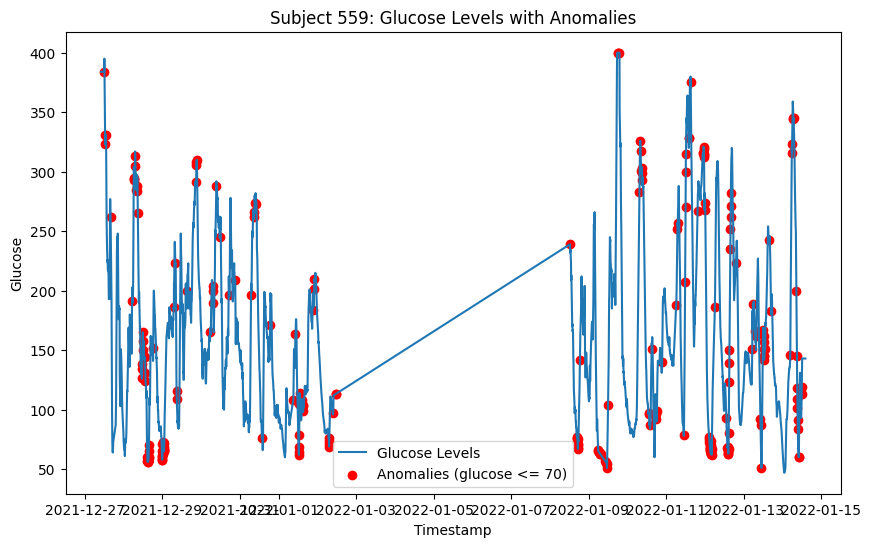

Precision: 0.314
Recall: 0.378
F1 Score: 0.343
Accuracy: 0.917
ROC-AUC Score: 0.664
Silhouette Score: 0.181


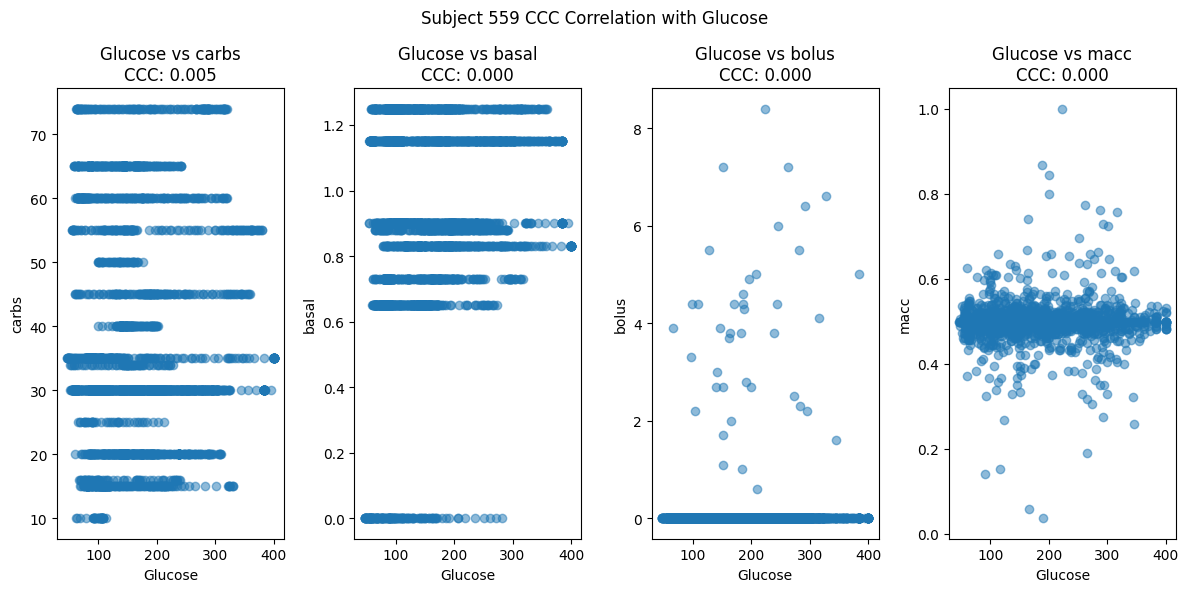

Processing subject 563
Train file for subject 563: /content/drive/MyDrive/OhioT1DM/OhioT1DM/2018/train/563-ws-training.xml
Test file for subject 563: /content/drive/MyDrive/OhioT1DM/OhioT1DM/2018/test/563-ws-testing.xml
Parsing train file: /content/drive/MyDrive/OhioT1DM/OhioT1DM/2018/train/563-ws-training.xml
Parsing test file: /content/drive/MyDrive/OhioT1DM/OhioT1DM/2018/test/563-ws-testing.xml
                      ts  glucose  basal  bolus      macc  carbs  Subject_ID
6313 2021-10-05 10:35:00    163.0    0.8    0.0  0.502674   16.0         563
6314 2021-10-05 10:40:00    163.0    0.8    0.0  0.529412   16.0         563
6315 2021-10-05 10:45:00    163.0    0.8    0.0  0.486631   16.0         563
6316 2021-10-05 10:50:00    163.0    0.8    0.0  0.497326   16.0         563
6317 2021-10-05 10:55:00    163.0    0.8    0.0  0.497326   16.0         563
6318 2021-10-05 11:00:00    163.0    0.8    0.0  0.502674   16.0         563
6319 2021-10-05 11:05:00    163.0    0.8    0.0  0.502674   

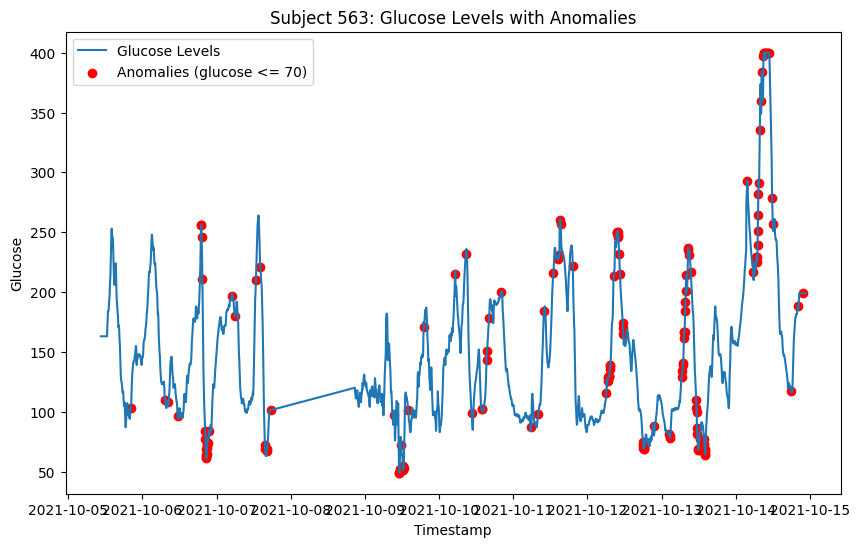

Precision: 0.176
Recall: 0.619
F1 Score: 0.274
Accuracy: 0.944
ROC-AUC Score: 0.784
Silhouette Score: 0.299


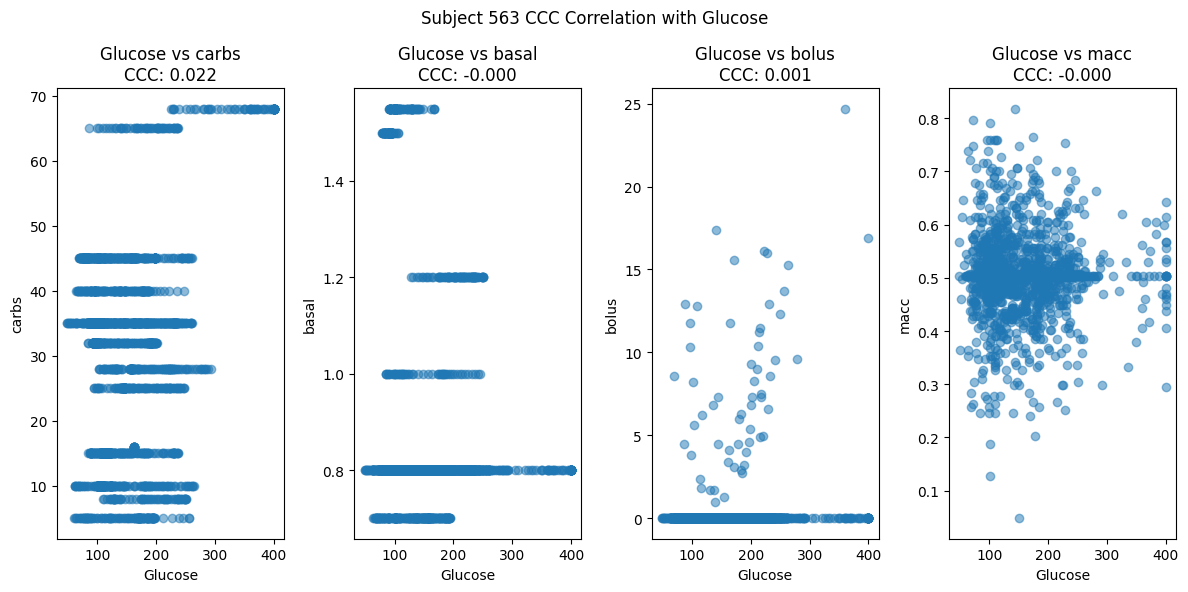

Processing subject 570
Train file for subject 570: /content/drive/MyDrive/OhioT1DM/OhioT1DM/2018/train/570-ws-training.xml
Test file for subject 570: /content/drive/MyDrive/OhioT1DM/OhioT1DM/2018/test/570-ws-testing.xml
Parsing train file: /content/drive/MyDrive/OhioT1DM/OhioT1DM/2018/train/570-ws-training.xml
Parsing test file: /content/drive/MyDrive/OhioT1DM/OhioT1DM/2018/test/570-ws-testing.xml
Empty DataFrame
Columns: [ts, glucose, basal, bolus, macc, carbs, Subject_ID]
Index: []
Input DataFrame is None or empty. Skipping this subject.
Skipping subject 570 due to lack of sufficient normal glucose data.
Processing subject 575
Train file for subject 575: /content/drive/MyDrive/OhioT1DM/OhioT1DM/2018/train/575-ws-training.xml
Test file for subject 575: /content/drive/MyDrive/OhioT1DM/OhioT1DM/2018/test/575-ws-testing.xml
Parsing train file: /content/drive/MyDrive/OhioT1DM/OhioT1DM/2018/train/575-ws-training.xml
Parsing test file: /content/drive/MyDrive/OhioT1DM/OhioT1DM/2018/test/575-

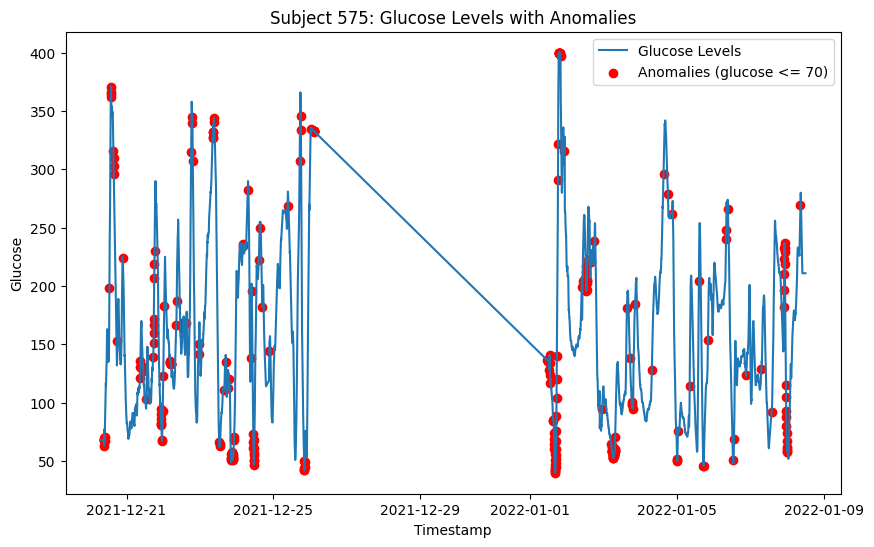

Precision: 0.373
Recall: 0.421
F1 Score: 0.395
Accuracy: 0.914
ROC-AUC Score: 0.685
Silhouette Score: 0.242


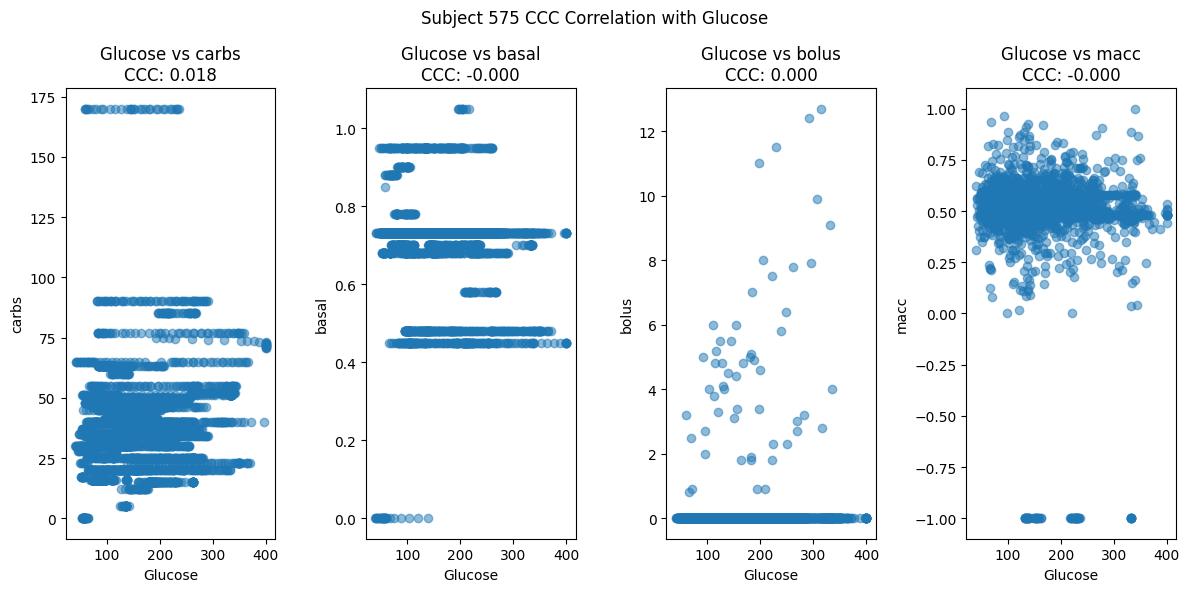

Processing subject 588
Train file for subject 588: /content/drive/MyDrive/OhioT1DM/OhioT1DM/2018/train/588-ws-training.xml
Test file for subject 588: /content/drive/MyDrive/OhioT1DM/OhioT1DM/2018/test/588-ws-testing.xml
Parsing train file: /content/drive/MyDrive/OhioT1DM/OhioT1DM/2018/train/588-ws-training.xml
Parsing test file: /content/drive/MyDrive/OhioT1DM/OhioT1DM/2018/test/588-ws-testing.xml
                       ts  glucose  basal  bolus      macc  carbs  Subject_ID
11774 2021-10-10 09:00:00    105.0   1.25    0.0  0.517699   60.0         588
11775 2021-10-10 09:05:00    105.0   1.25    0.0  0.513274   60.0         588
11776 2021-10-10 09:10:00    105.0   1.25    0.0  0.522124   60.0         588
11777 2021-10-10 09:15:00    105.0   1.25    2.0  0.508850   60.0         588
11778 2021-10-10 09:20:00    105.0   1.25    0.0  0.482301   15.0         588
11779 2021-10-10 09:25:00    105.0   1.25    0.0  0.508850   15.0         588
11780 2021-10-10 09:30:00    105.0   1.25    0.0  0.5

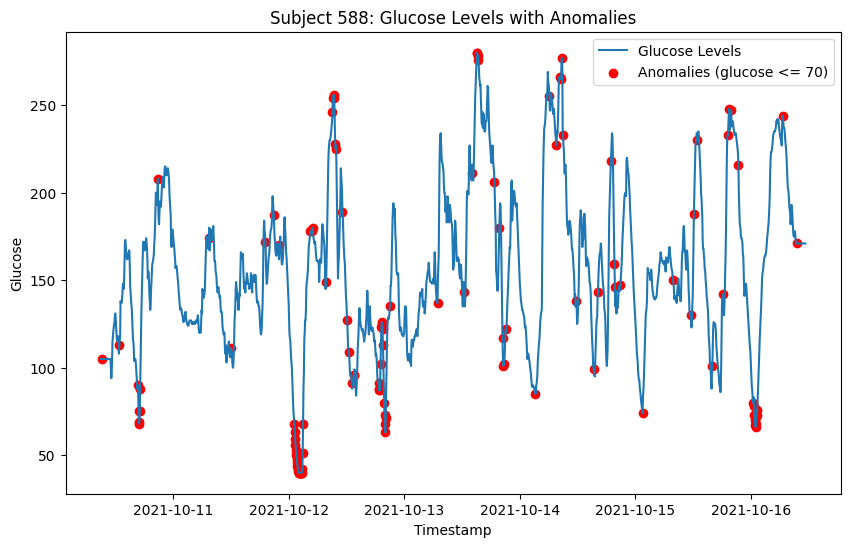

Precision: 0.258
Recall: 1.000
F1 Score: 0.411
Accuracy: 0.949
ROC-AUC Score: 0.974
Silhouette Score: 0.470


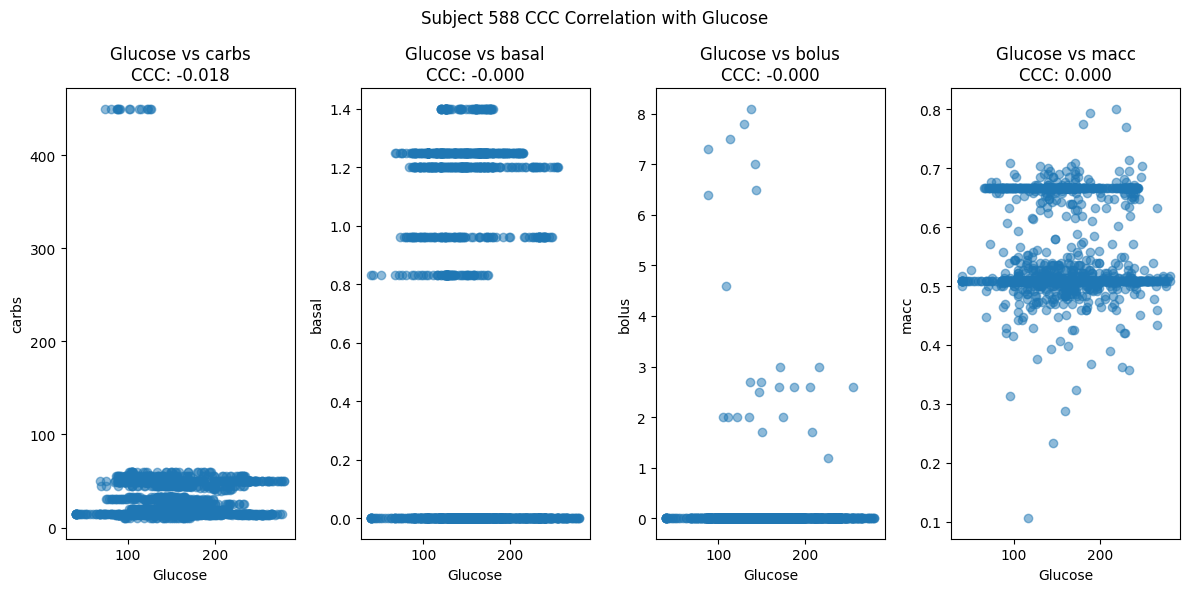

Processing subject 591
Train file for subject 591: /content/drive/MyDrive/OhioT1DM/OhioT1DM/2018/train/591-ws-training.xml
Test file for subject 591: /content/drive/MyDrive/OhioT1DM/OhioT1DM/2018/test/591-ws-testing.xml
Parsing train file: /content/drive/MyDrive/OhioT1DM/OhioT1DM/2018/train/591-ws-training.xml
Parsing test file: /content/drive/MyDrive/OhioT1DM/OhioT1DM/2018/test/591-ws-testing.xml
                      ts  glucose  basal  bolus      macc  carbs  Subject_ID
4007 2021-12-14 15:00:00    105.0   0.93    0.0  0.469388   37.0         591
4008 2021-12-14 15:05:00    105.0   0.93    0.0  0.469388   37.0         591
4009 2021-12-14 15:10:00    105.0   0.93    0.0  0.469388   37.0         591
4010 2021-12-14 15:15:00    105.0   0.93    0.0  0.469388   37.0         591
4011 2021-12-14 15:20:00    105.0   0.93    0.0  0.469388   37.0         591
4012 2021-12-14 15:25:00    105.0   0.93    0.0  0.469388   37.0         591
4013 2021-12-14 15:30:00    105.0   0.93    0.0  0.469388   

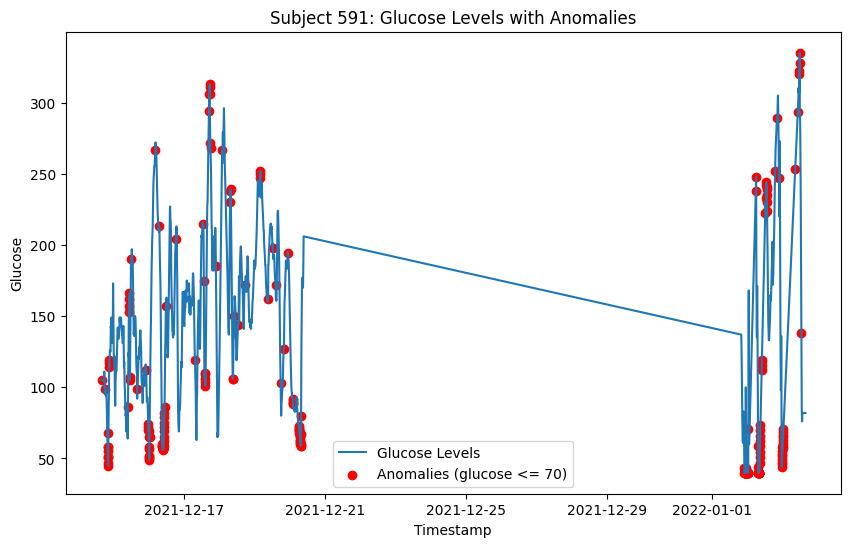

Precision: 0.529
Recall: 0.730
F1 Score: 0.614
Accuracy: 0.936
ROC-AUC Score: 0.841
Silhouette Score: 0.270


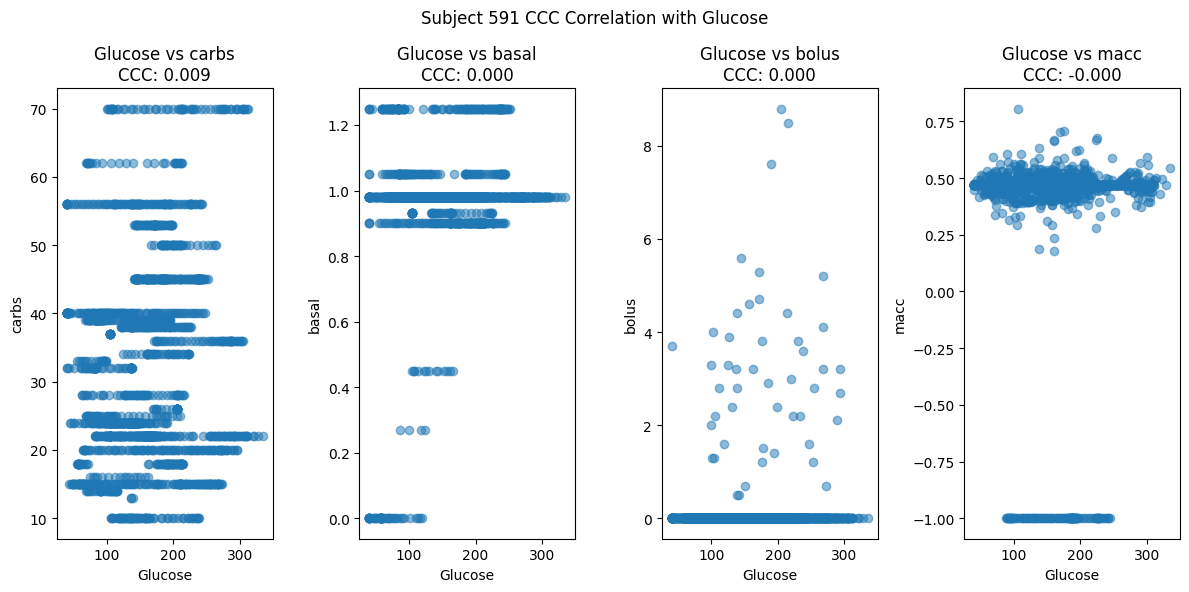

Processing subject 540
Train file for subject 540: /content/drive/MyDrive/OhioT1DM/OhioT1DM/2020/train/540-ws-training.xml
Test file for subject 540: /content/drive/MyDrive/OhioT1DM/OhioT1DM/2020/test/540-ws-testing.xml
Parsing train file: /content/drive/MyDrive/OhioT1DM/OhioT1DM/2020/train/540-ws-training.xml
Parsing test file: /content/drive/MyDrive/OhioT1DM/OhioT1DM/2020/test/540-ws-testing.xml
                       ts  glucose  basal  bolus  macc  carbs  Subject_ID
11290 2027-06-27 16:25:00     94.0    0.0    0.0  -1.0  100.0         540
11291 2027-06-27 16:30:00     94.0    0.0    0.0  -1.0  100.0         540
11292 2027-06-27 16:35:00     94.0    0.0    0.0  -1.0  100.0         540
11293 2027-06-27 16:40:00     94.0    0.0    0.0  -1.0  100.0         540
11294 2027-06-27 16:45:00     94.0    0.0    0.0  -1.0  100.0         540
11295 2027-06-27 16:50:00     94.0    0.0    0.0  -1.0  100.0         540
11296 2027-06-27 16:55:00     94.0    0.0    0.0  -1.0  100.0         540
11297 2

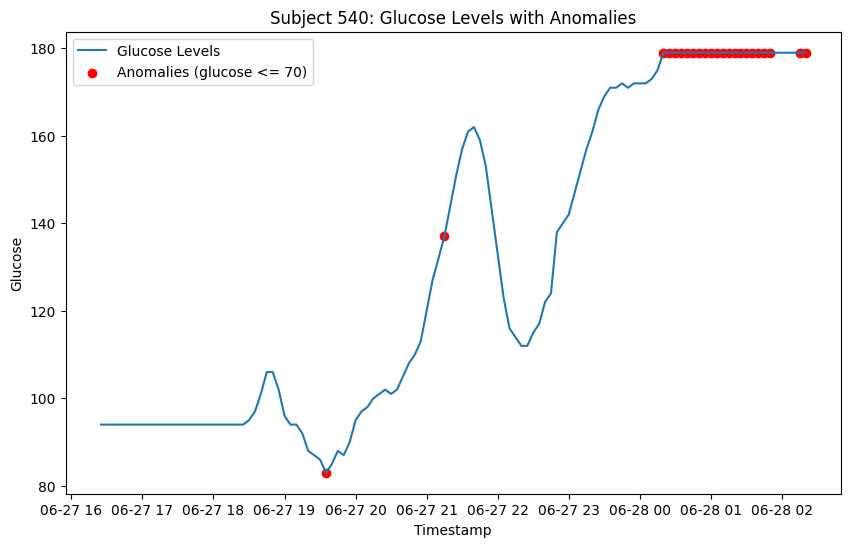

Accuracy: 0.808
Silhouette Score: 0.352


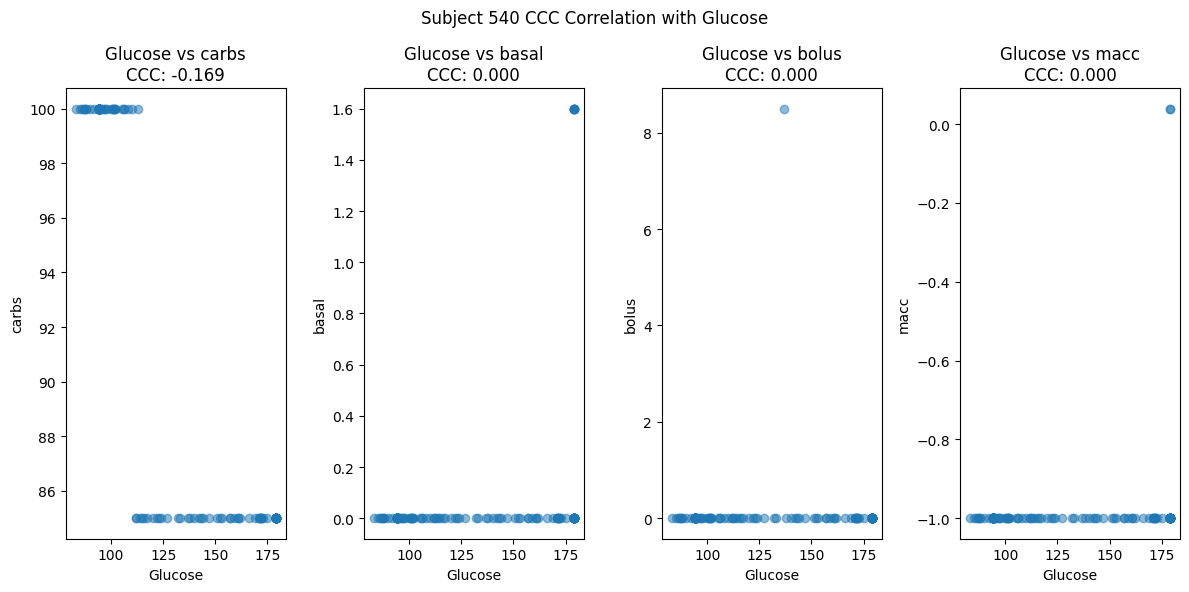

Processing subject 544
Train file for subject 544: /content/drive/MyDrive/OhioT1DM/OhioT1DM/2020/train/544-ws-training.xml
Test file for subject 544: /content/drive/MyDrive/OhioT1DM/OhioT1DM/2020/test/544-ws-testing.xml
Parsing train file: /content/drive/MyDrive/OhioT1DM/OhioT1DM/2020/train/544-ws-training.xml
Parsing test file: /content/drive/MyDrive/OhioT1DM/OhioT1DM/2020/test/544-ws-testing.xml
                      ts  glucose  basal  bolus      macc  carbs  Subject_ID
1810 2027-05-17 06:50:00    178.0    1.5    0.0  0.002488   20.0         544
1811 2027-05-17 06:55:00    178.0    1.5    0.0  0.003213   20.0         544
1812 2027-05-17 07:00:00    178.0    1.5    0.0  0.003938   20.0         544
1813 2027-05-17 07:05:00    178.0    1.5    0.0  0.004663   20.0         544
1814 2027-05-17 07:10:00    178.0    1.5    0.0  0.005387   20.0         544
1815 2027-05-17 07:15:00    178.0    1.5    0.0  0.006112   20.0         544
1816 2027-05-17 07:20:00    178.0    1.5    0.0  0.006837   

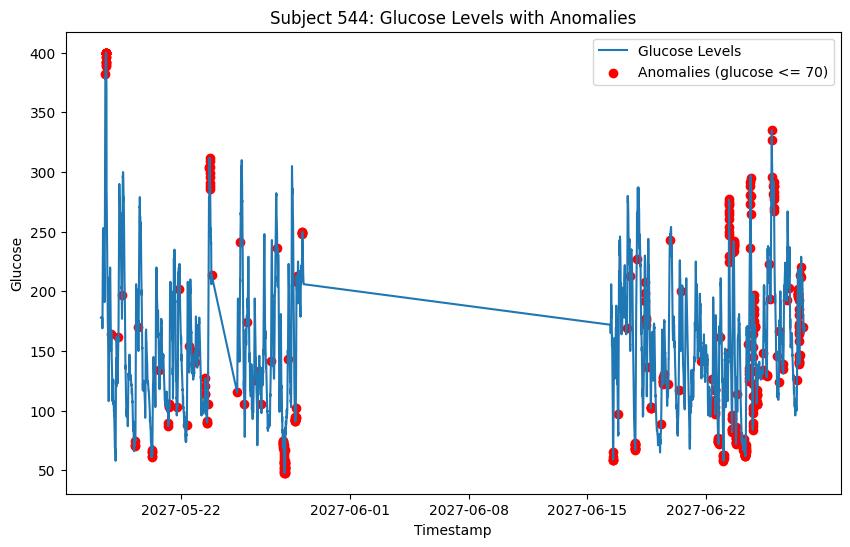

Precision: 0.205
Recall: 0.614
F1 Score: 0.307
Accuracy: 0.943
ROC-AUC Score: 0.782
Silhouette Score: 0.257


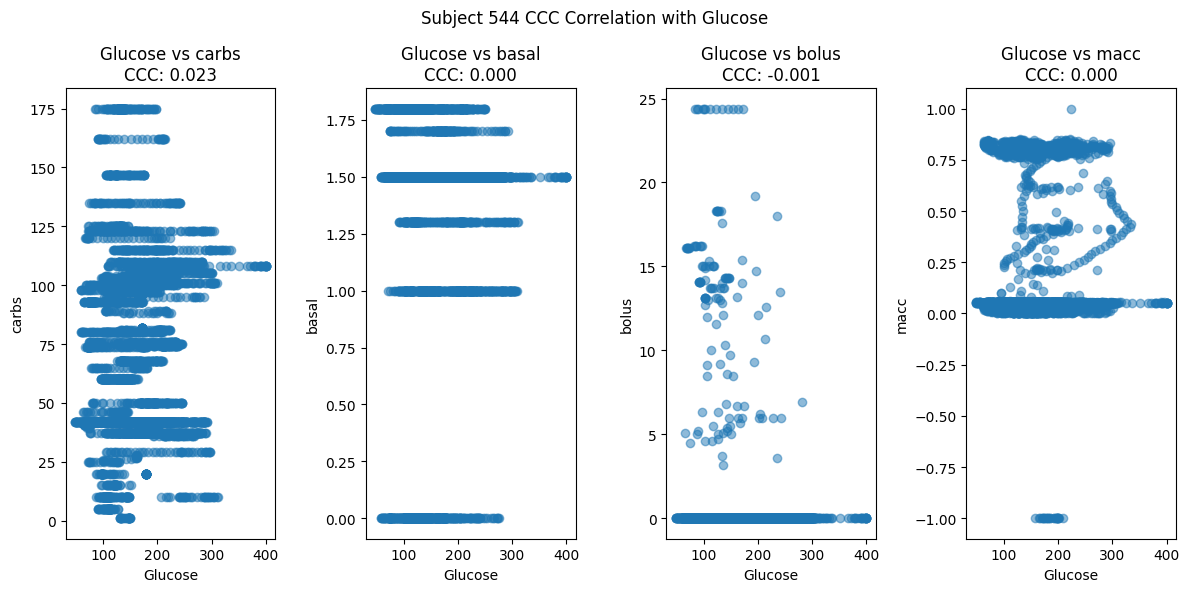

Processing subject 552
Train file for subject 552: /content/drive/MyDrive/OhioT1DM/OhioT1DM/2020/train/552-ws-training.xml
Test file for subject 552: /content/drive/MyDrive/OhioT1DM/OhioT1DM/2020/test/552-ws-testing.xml
Parsing train file: /content/drive/MyDrive/OhioT1DM/OhioT1DM/2020/train/552-ws-training.xml
Parsing test file: /content/drive/MyDrive/OhioT1DM/OhioT1DM/2020/test/552-ws-testing.xml
Empty DataFrame
Columns: [ts, glucose, basal, bolus, macc, carbs, Subject_ID]
Index: []
Input DataFrame is None or empty. Skipping this subject.
Skipping subject 552 due to lack of sufficient normal glucose data.
Processing subject 567
Train file for subject 567: /content/drive/MyDrive/OhioT1DM/OhioT1DM/2020/train/567-ws-training.xml
Test file for subject 567: /content/drive/MyDrive/OhioT1DM/OhioT1DM/2020/test/567-ws-testing.xml
Parsing train file: /content/drive/MyDrive/OhioT1DM/OhioT1DM/2020/train/567-ws-training.xml
Parsing test file: /content/drive/MyDrive/OhioT1DM/OhioT1DM/2020/test/567-

ValueError: cannot insert ts, already exists

In [162]:
import os

def main():
    versions_arr = [2018, 2020]

    for v in versions_arr:
        if v == 2018:
            patient_index = [559, 563, 570, 575, 588, 591]
            train_files = [
                '/content/drive/MyDrive/OhioT1DM/OhioT1DM/2018/train/559-ws-training.xml',
                '/content/drive/MyDrive/OhioT1DM/OhioT1DM/2018/train/563-ws-training.xml',
                '/content/drive/MyDrive/OhioT1DM/OhioT1DM/2018/train/570-ws-training.xml',
                '/content/drive/MyDrive/OhioT1DM/OhioT1DM/2018/train/575-ws-training.xml',
                '/content/drive/MyDrive/OhioT1DM/OhioT1DM/2018/train/588-ws-training.xml',
                '/content/drive/MyDrive/OhioT1DM/OhioT1DM/2018/train/591-ws-training.xml'
            ]
            test_files = [
                '/content/drive/MyDrive/OhioT1DM/OhioT1DM/2018/test/559-ws-testing.xml',
                '/content/drive/MyDrive/OhioT1DM/OhioT1DM/2018/test/563-ws-testing.xml',
                '/content/drive/MyDrive/OhioT1DM/OhioT1DM/2018/test/570-ws-testing.xml',
                '/content/drive/MyDrive/OhioT1DM/OhioT1DM/2018/test/575-ws-testing.xml',
                '/content/drive/MyDrive/OhioT1DM/OhioT1DM/2018/test/588-ws-testing.xml',
                '/content/drive/MyDrive/OhioT1DM/OhioT1DM/2018/test/591-ws-testing.xml'
            ]
        elif v == 2020:
            patient_index = [540, 544, 552, 567, 584, 596]
            train_files = [
                '/content/drive/MyDrive/OhioT1DM/OhioT1DM/2020/train/540-ws-training.xml',
                '/content/drive/MyDrive/OhioT1DM/OhioT1DM/2020/train/544-ws-training.xml',
                '/content/drive/MyDrive/OhioT1DM/OhioT1DM/2020/train/552-ws-training.xml',
                '/content/drive/MyDrive/OhioT1DM/OhioT1DM/2020/train/567-ws-training.xml',
                '/content/drive/MyDrive/OhioT1DM/OhioT1DM/2020/train/584-ws-training.xml',
                '/content/drive/MyDrive/OhioT1DM/OhioT1DM/2020/train/596-ws-training.xml'
            ]
            test_files = [
                '/content/drive/MyDrive/OhioT1DM/OhioT1DM/2020/test/540-ws-testing.xml',
                '/content/drive/MyDrive/OhioT1DM/OhioT1DM/2020/test/544-ws-testing.xml',
                '/content/drive/MyDrive/OhioT1DM/OhioT1DM/2020/test/552-ws-testing.xml',
                '/content/drive/MyDrive/OhioT1DM/OhioT1DM/2020/test/567-ws-testing.xml',
                '/content/drive/MyDrive/OhioT1DM/OhioT1DM/2020/test/584-ws-testing.xml',
                '/content/drive/MyDrive/OhioT1DM/OhioT1DM/2020/test/596-ws-testing.xml'
            ]
        # Process each subject
        for idx, subject_id in enumerate(patient_index):
            print(f"Processing subject {subject_id}")

            # Ensure that the train and test files are valid XML files
            train_file = train_files[idx]
            test_file = test_files[idx]

            # Debugging file paths
            print(f"Train file for subject {subject_id}: {train_file}")
            print(f"Test file for subject {subject_id}: {test_file}")

            # Load data for the current subject
            combined_df = load_data([train_file], [test_file], [subject_id], version=v)

            if combined_df is None:
                print(f"Skipping subject {subject_id} due to data loading issues.")
                continue
            # Display the combined_df table after loading and processing
            print(combined_df.head(20))  # This will print the first few rows of combined_df

             # save to CSV for later inspection
            combined_df.to_csv(f"combined_data_subject_{subject_id}.csv", index=False)
            # --- Step 1: Data Preprocessing ---
            # Check for NaN values and fill them if necessary
            combined_df = combined_df.ffill().bfill()

            # Apply One-Class SVM
            combined_df = apply_one_class_svm(combined_df)

            if combined_df is None:
                print(f"Skipping subject {subject_id} due to lack of sufficient normal glucose data.")
                continue

            # Plot anomalies and evaluate model
            plot_anomalies(combined_df, subject_id)
            synthetic_labels = create_synthetic_labels(combined_df)
            evaluate_with_labels(combined_df, synthetic_labels)
            evaluate_roc_auc(combined_df, synthetic_labels)
            evaluate_silhouette_score(combined_df)

            # --- Step 2: Plot CCC correlations ---
            # Select features you want to visualize with glucose
            features_to_compare = ['carbs', 'basal', 'bolus', 'macc']  # Example features
            plot_ccc(combined_df, features_to_compare, subject_id)

if __name__ == '__main__':
    main()
